In [1]:
import Pkg

Pkg.activate(@__DIR__)

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [33]:
using Revise
using JuMP
using ToQUBO                 #px/indicator
using DisjunctiveProgramming #master
using DisjunctiveToQUBO
using QUBOTools
using LinearAlgebra
using HiGHS
using DWave
using AmplNLWriter

In [34]:
using Couenne_jll
const Couenne_Optimizer = () -> AmplNLWriter.Optimizer(Couenne_jll.amplexe);

In [3]:
includet("circles.jl")

$$
\begin{array}{rll}
    \displaystyle \min_{\mathbf{x}, \mathbf{Y}} & x_1 - x_2 + y_1 + 5y_2 \\
    \textrm{s.t.} & Y_1 \veebar Y_2 \\[0.75em]
                  & \displaystyle%
                    \left[\begin{array}{c} Y_{1} \\ (x_{1} + 1)^2 + (x_2 + 1)^2 \leq 1 \end{array}\right]
                    \bigvee
                    \left[\begin{array}{c} Y_{2} \\ (x_{1} - 1)^2 + (x_2 - 1)^2 \leq 1 \end{array}\right] \\[1.75em]
                  & -2 \leq x_{i} \leq 2 & \forall i \\
                  & Y_{i} \iff y_{i} = 1 & \forall i \\
                  & Y_{i} \in \{\textrm{True}, \textrm{False}\} & \forall i \\
                  & y_{i} \in \{0, 1\} & \forall i \\[1em]
\end{array}
$$

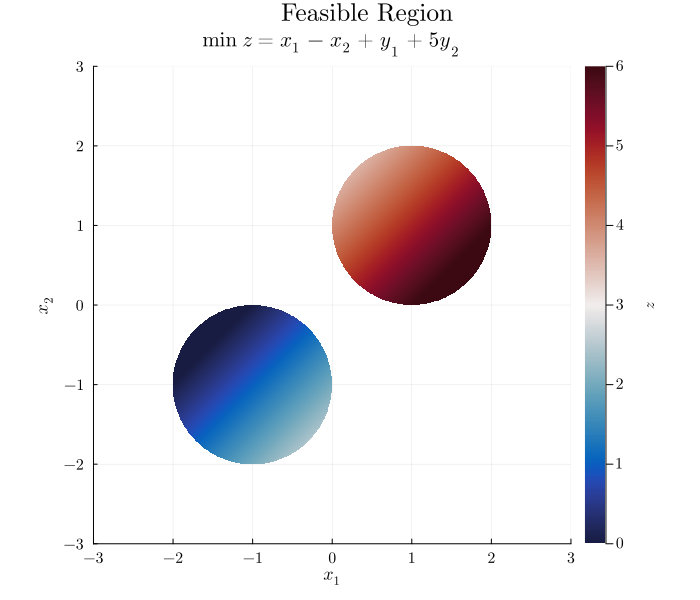

In [4]:
plot_circle_feasible()

## Optimal Solution

In [44]:
x⃰, z⃰ = let model = solve_gdp_circles(Couenne_Optimizer; method=BigM(5.0, false)) do m
        
    end
    
    value.(model[:x]), objective_value(model)
end

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 


ANALYSIS TEST: NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT -0.19895793        8 0.041676
Couenne: new cutoff value -1.9895789659e-01 (0.160117 seconds)
NLP0014I             2         OPT -0.19895791        4 0.01441
Loaded instance "/tmp/jl_hxmMWi/model.nl"
Constraints:            3
Variables:              4 (2 integer)
Auxiliaries:            5 (1 integer)

Coin0506I Presolve 15 (-2) rows, 5 (-4) columns and 35 (-5) elements
Clp0006I 0  Obj -2.5 Primal inf 8.6981017 (8)
Clp0006I 8  Obj -0.22755571
Clp0000I Optimal - objective value -0.22755571
Clp0032I Optimal objective -0.2275557119 - 8 iterations time 0.012, Presolve 0.00
Clp0000I Optimal - objective value -0.22755571
Cbc0012I Integer solution of -0.19895791 found by Couenne Rounding NLP after 0 iterations and 0 nodes (0.00 seconds)
NLP Heuristic: NLP0014I             3         OPT -0.19895791        3 0.033375
solution found, obj. -0.198958


([-1.2244789570792942, -0.0255210429084094], -0.19895791417088482)

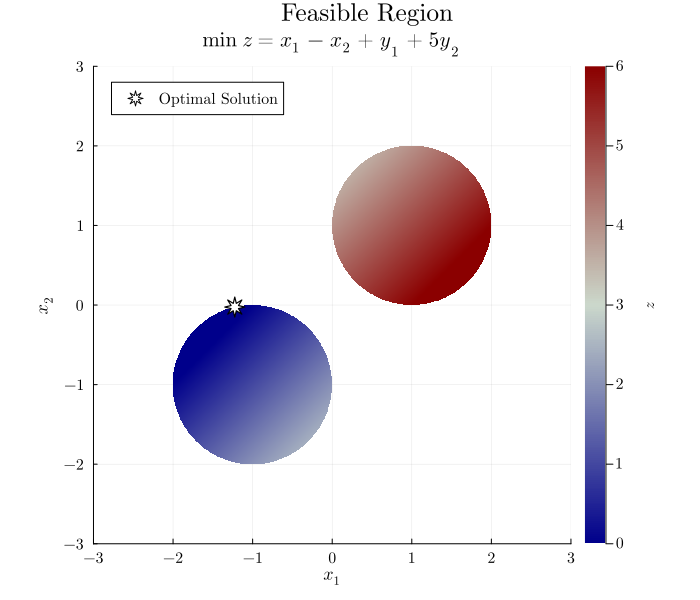

In [45]:
plot_circle_optimal(x⃰)

## Big-$M$ Reformulation

In [46]:
M = 5.0

bigm_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 8)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(bigm_model)
sampling_summary(bigm_model, z⃰)
solution_summary(bigm_model)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 3393
  Encoding ………………… 18
  Slack ………………………… 15
  Quadratization … 3360

⋄ Density
  Linear ……………………… 0.9997052755673446
  Quadratic ……………… 0.001991649011004899

⋄ Coefficient Range
  Lower Bound ………… -21120.0
  Upper Bound ………… 153600.0

⋄ Constant Offset: 38415.0

⋄ Work counters
  Compiltaion Time (sec) : 0.023146358

⋄ Sampling Summary

⋄ Number of samples: 1000

⋄ Best energy: 4.0

⋄ Time-to-target (sec): -Inf



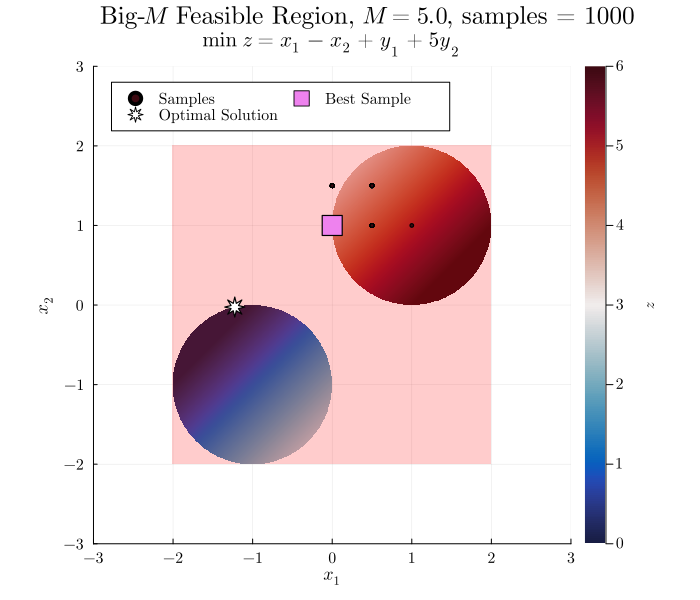

In [47]:
plot_circle_bigm(bigm_model, x⃰, M)

## Hull Reformulation

In [30]:
hull_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Hull()
) do m
    set_attribute(m, "num_reads",  100)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(hull_model)
solution_summary(hull_model)
sampling_summary(hull_model, z⃰)

ErrorException: Constraints of type MathOptInterface.ScalarNonlinearFunction-in-MathOptInterface.LessThan{Float64} are not supported by the solver.

If you expected the solver to support your problem, you may have an error in your formulation. Otherwise, consider using a different solver.

The list of available solvers, along with the problem types they support, is available at https://jump.dev/JuMP.jl/stable/installation/#Supported-solvers.

In [31]:
plot_reactor_hull(hull_model, x⃰)

UndefVarError: UndefVarError: `plot_reactor_hull` not defined

## Indicator Refoormulation

In [24]:
ind_model = solve_gdp_circles(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Indicator()
) do m
    # set_attribute(m, "num_reads", 2_000)
    # set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(ind_model)
solution_summary(ind_model)
sampling_summary(ind_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 312
  Encoding ………………… 10
  Slack ………………………… 7
  Quadratization … 295

⋄ Density
  Linear ……………………… 0.9775641025641025
  Quadratic ……………… 0.021044603842031495

⋄ Coefficient Range
  Lower Bound ………… -1200.0
  Upper Bound ………… 6960.0

⋄ Constant Offset: 15.0

⋄ Work counters
  Compiltaion Time (sec) : 0.420011448

⋄ Sampling Summary

⋄ Number of samples: 1000

⋄ Best energy: -2.0

⋄ Time-to-target (sec): 12389.223802738228



┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/pedroxavier/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/pedroxavier/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528


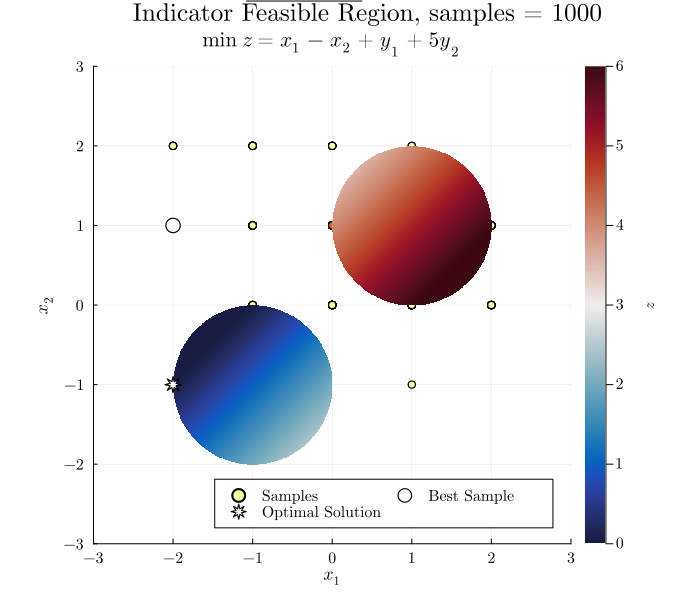

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots /home/pedroxavier/.julia/packages/Plots/sxUvK/src/backends/gr.jl:528


In [28]:
plot_circle_indicator(ind_model, x⃰)

## Indicator-Interval Reformulation

In [59]:
struct DisjunctEncoding{T} <: ToQUBO.Encoding.VariableEncodingMethod end

DisjunctEncoding() = DisjunctEncoding{Float64}()

ToQUBO.PBO.varshow(v::ToQUBO.VI) = ToQUBO.PBO.varshow(v.value)

In [74]:
function solve_indint_squares()
    model = Model(() -> ToQUBO.Optimizer(DWave.Neal.Optimizer))

    @variable(model, 0 <= x[1:2] <= 5)
    @variable(model, y[1:2], Bin)

    @objective(model, Min, cx'x + cy'y)
    
    @constraint(model, α'x ≥ d)
    
    @constraint(model, sum(y) == 1)
    # @constraint(model, y[1] => {x[2] ≤ 0.0})
    # @constraint(model, y[2] => {x[1] ≤ 0.0})


    set_attribute.(x, ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(x, ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())

    set_attribute(model, "num_reads", 2_000)
    set_attribute(model, "num_sweeps", 2_000)

    let virtual_model = unsafe_backend(model)::ToQUBO.Optimizer
        virtual_model.compiler_settings[:setup_callback] = m -> begin
            @info "Calling setup callback"
            y1 = only(ToQUBO.Encoding.encode!(m, y[1].index, ToQUBO.Encoding.Mirror()).y)
            y2 = only(ToQUBO.Encoding.encode!(m, y[2].index, ToQUBO.Encoding.Mirror()).y)

            let x1 = x[1].index
                z1, ξ, _ = ToQUBO.Encoding.encode(ToQUBO.Encoding.Unary(), (0.0, 5.0), 4) do (nv::Union{Integer,Nothing} = nothing)
                    if isnothing(nv)
                        return MOI.add_variable(m.target_model)
                    else
                        return MOI.add_variables(m.target_model, nv)
                    end
                end

                ξ1 = ToQUBO.PBO.PBF{ToQUBO.VI,Float64}(y2) * ξ
                v1 = ToQUBO.Virtual.Variable{Float64}(
                    DisjunctEncoding(), # new encoding method
                    x1,
                    z1,
                    ξ1,
                    nothing,
                )

                ToQUBO.Encoding.encode!(m, v1)
            end

            let x2 = x[2].index
                z2, ξ, _ = ToQUBO.Encoding.encode(ToQUBO.Encoding.Unary(), (0.0, 5.0), 4) do (nv::Union{Integer,Nothing} = nothing)
                    if isnothing(nv)
                        return MOI.add_variable(m.target_model)
                    else
                        return MOI.add_variables(m.target_model, nv)
                    end
                end

                ξ2 = ToQUBO.PBO.PBF{ToQUBO.VI,Float64}(y1) * ξ
                v2 = ToQUBO.Virtual.Variable{Float64}(
                    DisjunctEncoding(), # new encoding method
                    x2,
                    z2,
                    ξ2,
                    nothing,
                )

                ToQUBO.Encoding.encode!(m, v2)
            end
        end
    end

    set_attribute(model, ToQUBO.Attributes.Quadratize(), true)

    optimize!(model)

    return model
end

indint_model  = solve_indint_squares()
virtual_model = unsafe_backend(indint_model)

compilation_summary(indint_model)
solution_summary(indint_model)
sampling_summary(indint_model, z⃰)

┌ Info: Calling setup callback
└ @ Main /home/pedroxavier/gits/DisjunctiveToQUBO.jl/notebooks/reactors.ipynb:24


⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 117
  Encoding ………………… 10
  Slack ………………………… 7
  Quadratization … 100

⋄ Density
  Linear ……………………… 0.9316239316239316
  Quadratic ……………… 0.05511346890657236

⋄ Coefficient Range
  Lower Bound ………… -32638.75
  Upper Bound ………… 104448.0

⋄ Constant Offset: 58777.5

⋄ Work counters
  Compiltaion Time (sec) : 0.263966609

⋄ Sampling Summary

⋄ Number of samples: 2000

⋄ Best energy: 38.90000000002328

⋄ Time-to-target (sec): -Inf



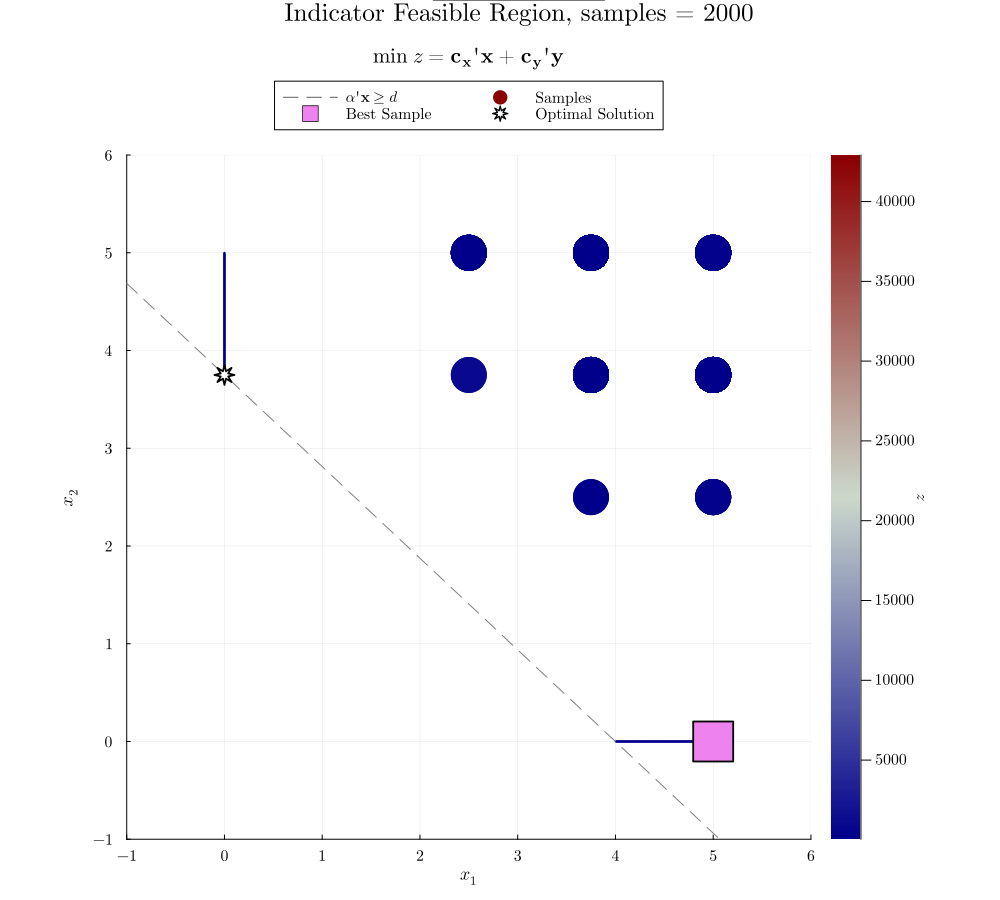

In [77]:
plot_reactor_indicator(indint_model, x⃰)